In [101]:
import pandas as pd
import os
import glob
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('ggplot')

pd.options.display.float_format = '{:,.2f}'.format

# Load loan data files
path=r'C:\UniSyd\DataScience\LendingClub\LoanData'
all_files = glob.glob(os.path.join(path, "*.csv")) 
loan_data=pd.concat((pd.read_csv(f,header=0,skiprows=1,low_memory=False) for f in all_files), ignore_index=True)
print ("loaded loan data files")

loaded loan data files


We will load the Rejected loan data into separate dataframe.

In [110]:
#Load Reject data files
path=r'C:\UniSyd\DataScience\LendingClub\RejectsData'
all_files = glob.glob(os.path.join(path, "*.csv")) 
reject_data=pd.concat((pd.read_csv(f,header=0,skiprows=1,low_memory=False) for f in all_files), ignore_index=True)
print ("loaded reject data files")

loaded reject data files


In [111]:
pd.options.display.float_format = '{:,.2f}'.format
#print (df1.shape,df2.shape,df3.shape,df4.shape)
print (loan_data.shape,reject_data.shape)
reject_data.head(5)

reject_data["Policy Code"].value_counts()

(1321864, 113) (11079386, 9)


0    11048682
2       30704
Name: Policy Code, dtype: int64

In [20]:
reject_data.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,"1,000.00",2007-05-26,Wedding Covered but No Honeymoon,693.00,10%,481xx,NM,4 years,0
1,"1,000.00",2007-05-26,Consolidating Debt,703.00,10%,010xx,MA,< 1 year,0
2,"11,000.00",2007-05-27,Want to consolidate my debt,715.00,10%,212xx,MD,1 year,0
3,"6,000.00",2007-05-27,waksman,698.00,38.64%,017xx,MA,< 1 year,0
4,"1,500.00",2007-05-27,mdrigo,509.00,9.43%,209xx,MD,< 1 year,0


All the files contained a few lines of summary data and does not help us in our analysis. Below code deletes 17 such entries 

In [141]:
#frames=[df1,df2,df3,df4]
#result=pd.concat(frames,ignore_index=True)
#result.shape

loan_data.drop(loan_data[loan_data.id.str.contains('Total|Loans',na=False)==True].index,inplace=True)
print (loan_data.shape)
#loan_data.dropna(inplace=True,axis=0,how='all')
#print (loan_data.shape)

(1321847, 113)


Also the id and member_id columns does not have any data in them. Hence dropping them.

In [142]:
 #drops id and member_id as they have all NA

loan_data.drop('id',axis=1,inplace=True)
loan_data.drop('member_id',axis=1,inplace=True)


loan_data['issue_d']=pd.to_datetime(loan_data['issue_d'],format='%b-%Y')
loan_data['issue_d']=loan_data['issue_d'].dt.year


ValueError: time data 2011.0 does not match format '%b-%Y' (match)

We will be analysing the data across years . As of now there is no intention to do a monthly analysis and hence converting the column to hold year in which the loan was issued /rejected. 

In [113]:


reject_data['Application Date']=pd.to_datetime(reject_data['Application Date'],format='%Y-%m-%d')
reject_data['Application Date']=reject_data['Application Date'].dt.year

In [114]:
loan_data['issue_d'].fillna(0,inplace=True)
loan_data.issue_d_year=loan_data['issue_d'].astype(int)
loan_data['chargeoff_within_12_mths'].fillna(0,inplace=True)
loan_data.chargeoff_within_12_mths=loan_data['chargeoff_within_12_mths'].astype(int)
#loan_data.chargeoff_within_12_mths.unique()

Below code creates dataframes that describe the distribution of the approved loan data and rejected loan data in each year. 

In [115]:
loan_amt_by_year=loan_data[['issue_d','loan_amnt']].groupby('issue_d').agg({'loan_amnt':'count'})
loan_amt_by_grade=loan_data[['grade','loan_amnt']].groupby('grade').agg({'loan_amnt':'count'})

reject_data_by_year=reject_data[['Amount Requested','Application Date']].groupby('Application Date').agg({'Amount Requested':'count'})

data_by_year=pd.DataFrame(index=[2010,2011,2012,2013,2014,2015,2016])
data_by_year['originated']=loan_amt_by_year['loan_amnt']
data_by_year['rejected']=reject_data_by_year['Amount Requested']
data_by_year


,originated,rejected
2010,12537,112561
2011,21721,217792
2012,53367,337277
2013,134814,760942
2014,235629,1933700
2015,421095,2859379
2016,434407,4769874


The Loan status Charged Off indicates that the borrower has not made any payments for more than 150 days and any outstanding principal will be counted towards the loss to investor. Below we find the distribution of such Charged off loans across the loan grades assigned by LC.

In [125]:
risky_statuses=['Charged Off','Default','In Grace Period','Late(16-30 days)','Late(31-120 days)']
names={True:1,False:0}

loan_data['risky_status']=loan_data.loan_status.isin(risky_statuses).map(lambda x:names[x])
loan_data['prnc_charged_off']=loan_data['risky_status']*(loan_data['funded_amnt']-loan_data['total_pymnt'])
risky_by_year=loan_data[loan_data.risky_status==1][['issue_d','prnc_charged_off','funded_amnt','total_pymnt']].groupby('issue_d').agg({'prnc_charged_off':'sum','total_pymnt':'sum','funded_amnt':'count'})

risky_by_grade=loan_data[loan_data.risky_status==1][['issue_d','prnc_charged_off','funded_amnt','total_pymnt','grade']].groupby('grade').agg({'prnc_charged_off':'sum','total_pymnt':'sum','funded_amnt':'count'})



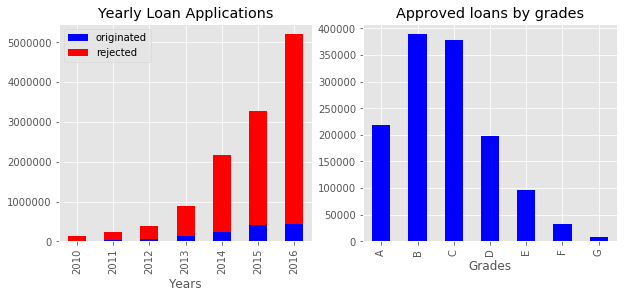

In [117]:

my_colors='br'
fig1, axs1 = plt.subplots(ncols=2 ,figsize=(10, 4))
data_by_year.plot(kind='bar',stacked=True,color=my_colors,title='Yearly Loan Applications',ax=axs1[0])
axs1[0].set_xlabel('Years')
loan_amt_by_grade.plot(kind='bar',color='b',title='Approved loans by grades',ax=axs1[1],legend=False)
axs1[1].set_xlabel('Grades')
fig1.savefig('TotalLoans.jpg')
#risky_by_year.loc[2010:2017]['prnc_charged_off'].plot(kind='bar',title='Trend of Charge Offs',ax=axs[0])
#axs[0].set_xlabel('Years')


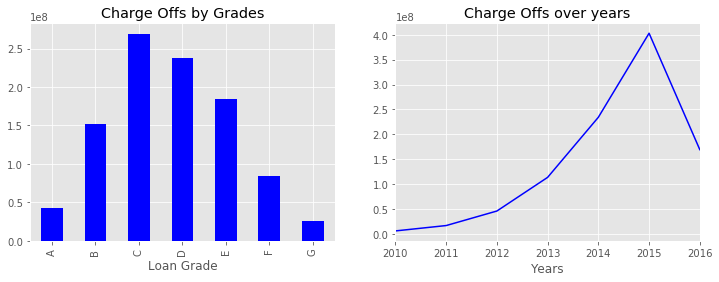

In [127]:
fig2,axs2=plt.subplots(ncols=2 ,figsize=(12, 4))
risky_by_grade['prnc_charged_off'].plot(kind='bar',title='Charge Offs by Grades',ax=axs2[0],color='b')
axs2[0].set_xlabel('Loan Grade')
risky_by_year.loc[2010:2017]['prnc_charged_off'].plot(kind='line',title='Charge Offs over years',ax=axs2[1],color='b')
axs2[1].set_xlabel('Years')
fig2.savefig('ChargedOff.jpg')

The distribution of loan statuses over the entire loans funded by LC

,funded_amnt
loan_status,
Charged Off,0.0845
Current,0.5540
Default,0.0000
Does not meet the credit policy. Status:Charged Off,0.0006
Does not meet the credit policy. Status:Fully Paid,0.0015
Fully Paid,0.3341
In Grace Period,0.0078
Late (16-30 days),0.0032
Late (31-120 days),0.0143


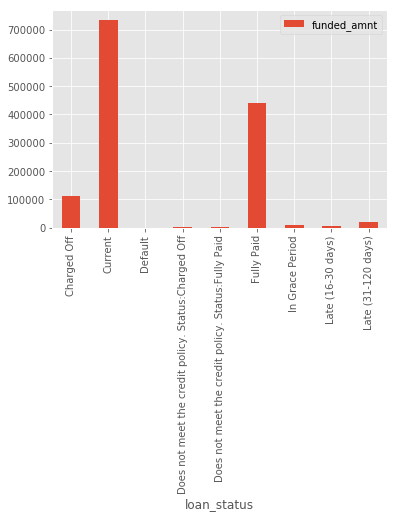

In [128]:
pd.options.display.float_format = '{:,.4f}'.format
loan_statuses=loan_data[['funded_amnt','loan_status','risky_status']]\
                        .groupby('loan_status').agg({'funded_amnt':'count'})
loan_statuses.plot(kind='bar')
loan_statuses/loan_data.shape[0]

Around 55% of the loans are in current state , 33% fully paid and the remaining loans are in the risky state (late or default or charged off)

Let us analyze the interest rate variation with respect to the loan grades. Run the below code only once to convert the data type to float by removing the % symbol.

In [55]:
loan_data['int_rate']=pd.Series(loan_data.int_rate).str.replace('%', '').astype(float)


,max_int,min_int,median_int,0.1quant,0.25quant,0.75quant,0.9quant
A,9.6300,5.3200,7.2600,5.3200,6.4900,7.8900,8.3900
B,14.0900,6.0000,10.7800,8.6700,9.4900,11.4900,12.3500
C,17.2700,6.0000,13.9800,12.2900,12.9900,14.6500,15.5900
D,21.4900,6.0000,17.5700,15.6100,16.5500,18.2500,19.4700
E,26.2400,6.0000,20.4900,18.2500,18.9900,21.9700,23.1000
F,30.7400,6.0000,24.0800,21.9900,23.1300,25.0900,26.4900
G,30.9900,6.0000,26.0600,24.7000,25.8000,28.1800,28.9900


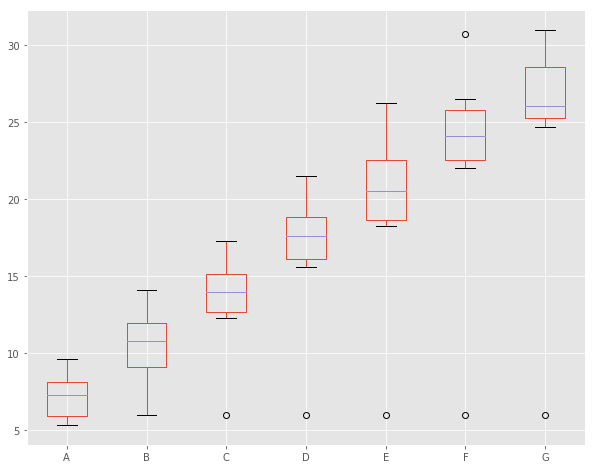

In [56]:
grouped=loan_data[['int_rate','grade']].groupby('grade')#.quantile(0.1)
int_rates=pd.DataFrame(index=['A','B','C','D','E','F','G'])
#int_rates['median_int']=pd.Series(grouped.quantile(0.5)['int_rate'])
#int_rates['0.1quant']=pd.Series(grouped.quantile(0.1)['int_rate'])
#int_rates['0.25quant']=pd.Series(grouped.quantile(0.25)['int_rate'])
int_rates['max_int']=grouped.max()
int_rates['min_int']=grouped.min()
int_rates['median_int']=grouped.median()
int_rates['0.1quant']=grouped.quantile(0.1)
int_rates['0.25quant']=grouped.quantile(0.25)
int_rates['0.75quant']=grouped.quantile(0.75)
int_rates['0.9quant']=grouped.quantile(0.9)


fig,axs=plt.subplots(ncols=1,figsize=(10,8))
int_rates.T.plot(kind='box',ax=axs)
int_rates

From above plots ,we can see the variation of interest rates with loan grades and interest rates for grade G could even reach 30% where as for grade A, it has never crossed 10%.

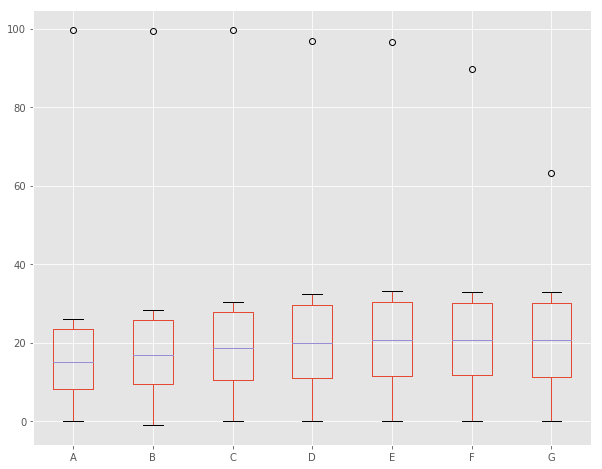

In [58]:
grouped_dti=loan_data[loan_data.dti<100][['dti','grade']].groupby('grade')
dti=pd.DataFrame(index=['A','B','C','D','E','F','G'])
dti['max']=grouped_dti.max()
dti['min']=grouped_dti.min()
dti['median']=grouped_dti.median()
dti['0.1q']=grouped_dti.quantile(0.1)
dti['0.25q']=grouped_dti.quantile(0.25)
dti['0.75q']=grouped_dti.quantile(0.75)
dti['0.9q']=grouped_dti.quantile(0.9)

fig,axs=plt.subplots(ncols=1,figsize=(10,8))
dti.T.plot(kind='box',ax=axs)


There are 73 rows in the years 2015 and 2016 where the dti is more than 1000. These would require further investigation  as they could be some masking attempts but as of now am ignoring them as outliers. I am restricting the maximum dti to 100 . From the graph , there seems to be a slightly increasing trend of dti across grades.

In [16]:
print (loan_data['addr_state'].value_counts()[:10])

CA    187415
NY    109594
TX    108175
FL     92668
IL     53192
NJ     49149
PA     45895
OH     44631
GA     43547
VA     37944
Name: addr_state, dtype: int64


In [17]:
print (reject_data.State.value_counts()[:10])

CA    1357999
TX     980237
NY     852543
FL     848734
PA     422871
GA     415387
IL     406951
OH     402379
NJ     348729
NC     346193
Name: State, dtype: int64


From both the above cells , it looks like CA,TX,NY,FL appear in top approved and rejected loans. There does not look like to be any state bias but we can decide while selecting features.

In [18]:
loan_data[loan_data.acc_now_delinq>0]['loan_status'].value_counts()

Current                                               4348
Fully Paid                                            1736
Charged Off                                            563
Late (31-120 days)                                     133
In Grace Period                                         63
Late (16-30 days)                                       30
Does not meet the credit policy. Status:Fully Paid       4
Default                                                  1
Name: loan_status, dtype: int64

Lot of current loans seem to have high debt to income ratio , previous delinquency ratio etc., 

In [19]:


#loan_data[loan_data.risky_status==1][['funded_amnt','total_pymnt','out_prncp','grade','prnc_charged_off']].groupby('grade').sum().plot(kind='bar')
loan_sub=loan_data[['loan_status','funded_amnt','out_prncp_inv','prnc_charged_off','total_pymnt','total_rec_int','total_rec_prncp','recoveries','issue_d','term','grade']]
loan_sub.groupby('grade').sum().sum()

funded_amnt        19,482,988,375.0000
out_prncp_inv       7,890,055,415.9700
prnc_charged_off      915,332,228.5119
total_pymnt        13,305,623,897.1425
total_rec_int       2,898,599,666.0900
total_rec_prncp    10,298,155,825.0396
recoveries            108,036,010.6630
dtype: float64

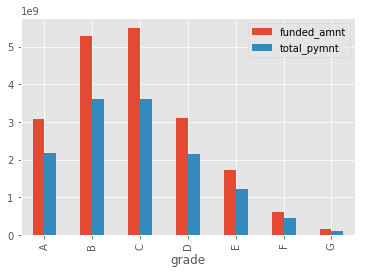

In [130]:


#loan_data['total_prncp_inc_recovery']=loan_data['total_rec_prncp']+loan_data['recoveries']+loan_data['']

loan_amt_by_grade=loan_data[['issue_d','loan_amnt','funded_amnt','grade','total_pymnt']].groupby('grade').agg({'funded_amnt':'sum','total_pymnt':'sum'})

loan_amt_by_grade.plot(kind='bar')


There is an attribute Chargeoff_within_12_mths . This indicates that despite being a defaulter in the last two months , people got funded for a loan again. Let us analyze to see if it is useful to predict loan defaults.

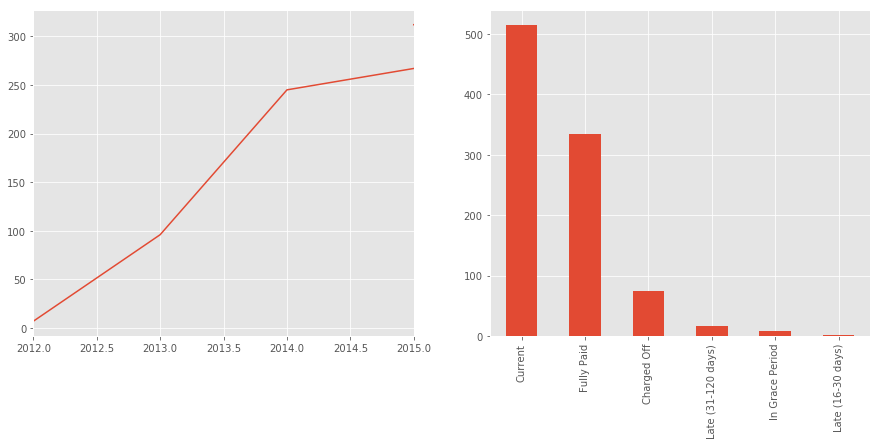

In [134]:
loan_after_chargeoff=loan_data[(loan_data.chargeoff_within_12_mths>1) ][['issue_d','funded_amnt','term','int_rate'
                                                 ,'grade','chargeoff_within_12_mths'
                                                 ,'total_rec_prncp'
                                                 ,'total_pymnt'
                                                 ,'loan_status'
                                                 ,'collection_recovery_fee'
                                                 ,'collections_12_mths_ex_med'
                                                ]]

fig_12mthchrgoff,axs_12mthchrgoff=plt.subplots(ncols=2,figsize=(15,6))
loan_after_chargeoff.issue_d.value_counts(sort=True,ascending=True).plot(ax=axs_12mthchrgoff[0])
loan_after_chargeoff.loan_status.value_counts().plot(kind='bar',ax=axs_12mthchrgoff[1])

Above table indicates that there are 949 cases since 2012 where borrowers had charged off more than once yet they did receive loans again. Though these are relatively less compared to the actual funded loans ,we can still see an increasing trend amongst these. Since majority of these were funded during 2015-2016 , they are still current but a lot of them are Fully paid. So we can't really say if there a strong relation with loan defaults.

In [23]:
loan_data.purpose.value_counts()


debt_consolidation    773152
credit_card           297803
home_improvement       83016
other                  71365
major_purchase         27683
small_business         15168
medical                13981
car                    13677
moving                  8644
vacation                7998
house                   5709
wedding                 2349
renewable_energy         879
educational              423
Name: purpose, dtype: int64

We can see that debt consolidation and credit card dominate the originated loans

## Feature selection for the loan status prediction task:


In [143]:
loan_data[~loan_data.grade.isin(['A','B','C','D','E','F','G'])]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,risky_status,prnc_charged_off


In [146]:
labels=loan_data.loan_status.as_matrix()

from sklearn import preprocessing
lenc=preprocessing.LabelEncoder()


lenc.fit(['A','B','C','D','E','F','G'])
loan_data['grade_enc']=loan_data.grade.map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
loan_data.grade_enc;



In [68]:
lenc.fit(loan_data.home_ownership.unique())
loan_data['home_own_enc']=lenc.transform(loan_data.home_ownership)
loan_data.home_own_enc;

In [69]:
lenc.fit(loan_data.addr_state.unique())
loan_data['state_enc']=lenc.transform(loan_data.addr_state)
loan_data.state_enc;

In [70]:
lenc.fit(loan_data.term.unique())
loan_data['term_enc']=lenc.transform(loan_data.term)
loan_data.term_enc;

In [71]:
loan_data['emp_length']=loan_data['emp_length'].str.replace('year|\+|<|s| ','')
loan_data['emp_length']=loan_data['emp_length'].str.replace('n/a','0')
loan_data['emp_length']=loan_data.emp_length.astype(int)
loan_data.emp_length.unique()

array([10,  1,  3,  8,  9,  4,  5,  6,  2,  7,  0], dtype=int64)

In [72]:
loan_data[['funded_amnt','issue_d','acc_now_delinq','state_enc','annual_inc','chargeoff_within_12_mths'\
                   ,'delinq_2yrs','delinq_amnt','dti','emp_length','grade_enc','home_own_enc','inq_last_6mths','inq_last_12m'\
                   ,'int_rate','issue_d','mort_acc','mths_since_last_delinq'
                   ,'mths_since_last_major_derog','num_accts_ever_120_pd','pct_tl_nvr_dlq','pub_rec_bankruptcies',\
                   'term_enc','total_acc']].dtypes

funded_amnt                    float64
issue_d                          int64
acc_now_delinq                 float64
state_enc                        int64
annual_inc                     float64
chargeoff_within_12_mths         int32
delinq_2yrs                    float64
delinq_amnt                    float64
dti                            float64
emp_length                       int32
grade_enc                        int64
home_own_enc                     int64
inq_last_6mths                 float64
inq_last_12m                   float64
int_rate                       float64
issue_d                          int64
mort_acc                       float64
mths_since_last_delinq         float64
mths_since_last_major_derog    float64
num_accts_ever_120_pd          float64
pct_tl_nvr_dlq                 float64
pub_rec_bankruptcies           float64
term_enc                         int64
total_acc                      float64
dtype: object

In [80]:
loan_data.drop('loan_status',inplace=True,axis=1)
reject_data=pd.DataFrame(index=['A'])
reject_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, A to A
Empty DataFrame

In [81]:
feature_array=['funded_amnt','acc_now_delinq','state_enc','annual_inc','chargeoff_within_12_mths'\
                   ,'delinq_2yrs','delinq_amnt','dti','emp_length','grade_enc','home_own_enc','inq_last_6mths','inq_last_12m'\
                   ,'int_rate','issue_d','mort_acc','mths_since_last_delinq'
                   ,'mths_since_last_major_derog','num_accts_ever_120_pd','pct_tl_nvr_dlq','pub_rec_bankruptcies',\
                   'term_enc','total_acc']
for feature in feature_array:
    loan_data[feature]=loan_data[feature].fillna(0)


In [98]:
features=loan_data[['funded_amnt','acc_now_delinq','state_enc','annual_inc','chargeoff_within_12_mths'\
                   ,'delinq_2yrs','delinq_amnt','dti','emp_length','grade_enc','home_own_enc','inq_last_6mths','inq_last_12m'\
                   ,'int_rate','issue_d','mort_acc','mths_since_last_delinq'
                   ,'mths_since_last_major_derog','num_accts_ever_120_pd','pct_tl_nvr_dlq','pub_rec_bankruptcies',\
                   'term_enc','total_acc']]
features.values

array([[  5.00000000e+03,   0.00000000e+00,   3.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   9.00000000e+00],
       [  2.50000000e+03,   0.00000000e+00,   1.00000000e+01, ...,
          0.00000000e+00,   1.00000000e+00,   4.00000000e+00],
       [  2.40000000e+03,   0.00000000e+00,   1.40000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+01],
       ..., 
       [  4.00000000e+04,   0.00000000e+00,   4.00000000e+00, ...,
          0.00000000e+00,   1.00000000e+00,   3.70000000e+01],
       [  2.40000000e+04,   0.00000000e+00,   9.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   3.10000000e+01],
       [  1.40000000e+04,   0.00000000e+00,   4.30000000e+01, ...,
          0.00000000e+00,   1.00000000e+00,   2.20000000e+01]])

In [83]:
features.dtypes

funded_amnt                    float64
acc_now_delinq                 float64
state_enc                        int64
annual_inc                     float64
chargeoff_within_12_mths         int32
delinq_2yrs                    float64
delinq_amnt                    float64
dti                            float64
emp_length                       int32
grade_enc                        int64
home_own_enc                     int64
inq_last_6mths                 float64
inq_last_12m                   float64
int_rate                       float64
issue_d                          int64
mort_acc                       float64
mths_since_last_delinq         float64
mths_since_last_major_derog    float64
num_accts_ever_120_pd          float64
pct_tl_nvr_dlq                 float64
pub_rec_bankruptcies           float64
term_enc                         int64
total_acc                      float64
dtype: object

In [86]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector=SelectKBest(f_classif,k=20)
features_new=selector.fit_transform(features,labels)
scores=selector.pvalues_
scores



array([  0.00000000e+000,   4.14775681e-048,   5.10626565e-100,
         0.00000000e+000,   4.83770582e-015,   0.00000000e+000,
         5.20850921e-008,   9.21318285e-104,   4.87783222e-205,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   1.69235318e-144,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   6.32971824e-074,
         0.00000000e+000,   0.00000000e+000])

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

clf=DecisionTreeClassifier()

features_train,features_test,labels_train,labels_test=train_test_split(features_new,labels,test_size=0.25,random_state=42)

scores=cross_val_score(clf,features_train,labels_train,cv=5,scoring='f1_macro')
scores


array([ 0.25697891,  0.25443219,  0.26003388,  0.25211746,  0.2457168 ])